In [11]:
import os
os.environ['QT_QPA_PLATFORM']='offscreen'

import ete3
from ete3 import Tree, TreeStyle, NodeStyle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
from Bio import Entrez

def readFasta(inFile):
    seqs = {}
    with open(inFile, 'r') as f:
        for s in f.read().split('>')[1:]:
            sl = s.split('\n')
            
            seqs[sl[0]] = ''.join(sl[1:])
        f.close()
            
    return seqs

#ssuAlign = readFasta('../16s_rrna_db/allGtRNAdb16sSeqs.align.fasta')
ssuAlign = readFasta('../../bac_phylo_ref/b_gtrnadb_combined_rrna_aligns.phylo_reference.fasta')

def writeFasta(data, outFile, block = 60, col = None):
    """Write fasta sequences from a dictionary of {header: sequence}"""
    
    if col == None: 
        with open(outFile, 'w') as outF:
            for seq in data.keys():
                outF.write('>' + seq + '\n')

                for b in range(0, len(data[seq]), block):
                    outF.write(data[seq][b: b + 60] + '\n')
            outF.close()
            
    else: #Else, use data frame
        with open(outFile, 'w') as outF:
            for seq in data.index.values:
                outF.write('>' + seq + '\n')
                
                
                try:
                    s = data.loc[seq, col]
                    for b in range(0, len(s), block):
                        outF.write(s[b: b + 60] + '\n')
                        
                except TypeError: #Handle if protein occurs more than once in dataframe (write only one entry)
                    s = data.loc[seq, col].tolist()[0]
                    
                    for b in range(0, len(s), block):
                        outF.write(s[b: b + 60] + '\n')
                    
            outF.close()
       




def readGtRNAdbInfo(file):
    info = {}
    
    cols = set() #Store different fields as columns
    
    with open(file, 'r') as f:
        
        #Make a first pass over the file to obtain info fields
        
        entries = f.read().split('\n\n')[1:]
        
        for e in entries:
            
            for a in e.split('\n'):
                cols.add(a.split(':')[0])
        info = {x: [] for x in cols}
        
        for x,e in enumerate(entries):
            
            entry = {x: '' for x in cols}
            for a in e.split('\n'):
                sa = a.split(':')
                
                i = sa[0]
                
                v = ':'.join(sa[1:]).lstrip()
                
                entry[i] = v
                
            for a in entry.keys():
                info[a].append(entry[a])
        f.close()
        
    return pd.DataFrame(info)
        
genomeInfo = readGtRNAdbInfo('../gtrnadb_genome_info.txt')
genomeInfo = genomeInfo.set_index(genomeInfo['DB_name'])
print(genomeInfo)




#Remove selected assemblies lacking Pro-UGG
genomeInfo = genomeInfo.drop(labels = ['lactGass_130918', 'mycoMele_B2096_8B', 'ureaDive_ATCC49782'], axis = 0)


FileNotFoundError: [Errno 2] No such file or directory: '../gtrnadb_genome_info.txt'

In [14]:
"""
Use GtRNAdb genomeInfo file to create carefully-filtered dataset to use in analysis:

- 1 assembly per represented species
- Only genera that have three or more species represented
- Remove species not classified into genera

Generate curated rRNA alignment file for reference dataset

"""

def writeFasta(data, outFile, block = 60, col = None):
    """Write fasta sequences from a dictionary of {header: sequence}"""
    
    if col == None: 
        with open(outFile, 'w') as outF:
            for seq in data.keys():
                outF.write('>' + seq + '\n')

                for b in range(0, len(data[seq]), block):
                    outF.write(data[seq][b: b + 60] + '\n')
            outF.close()
            
    else: #Else, use data frame
        with open(outFile, 'w') as outF:
            for seq in data.index.values:
                outF.write('>' + seq + '\n')
                
                
                try:
                    s = data.loc[seq, col]
                    for b in range(0, len(s), block):
                        outF.write(s[b: b + 60] + '\n')
                        
                except TypeError: #Handle if protein occurs more than once in dataframe (write only one entry)
                    s = data.loc[seq, col].tolist()[0]
                    
                    for b in range(0, len(s), block):
                        outF.write(s[b: b + 60] + '\n')
                    
            outF.close()
       



    
    
    
print(genomeInfo.columns)

def searchTaxid(taxid, email = 'htmoore@ucsc.edu'):
    Entrez.email = email
    search = Entrez.efetch(id = taxid, db = "taxonomy", retmode = "xml")
    i = Entrez.read(search)
    
    info = i[0]['LineageEx']
    
    linDict = {}
    
    for x in info:
        linDict[x['Rank']] = x['ScientificName']
    
    return linDict

# Import reference alignment database
# Import reference alignment database
alnFile = '../bac_phylo_ref/b_gtrnadb_combined_rrna_aligns.phylo_reference.fasta' 
aln = readFasta(alnFile)

def getSp(sp):
    spName = ''
    if sp.split(' ')[1] == 'sp.':
        spName = sp

    elif sp[0] == sp[0].upper():
        spName = ' '.join(sp.split(' ')[0:2])

    else:
        spName = sp
    
    return spName



#Remove sequences not present in the reference alignment
print(len(genomeInfo.index.values))
genomeInfo = genomeInfo.loc[genomeInfo.index.intersection(list(aln.keys())), :]
print(len(genomeInfo.index.values))

#store genus and phylum info from Entrez instead of using the unspecified tax info
genomeInfo['genus'] = '' 
genomeInfo['phylum'] = ''

# reduce to one assembly per species
spSet = set()

dbSet = []
for g in genomeInfo.index.values:
    sp = getSp(genomeInfo.loc[g, 'Org_name'])
    
    if sp not in spSet:
        dbSet.append(g)
        spSet.add(sp)
    else:
        pass
    
genomeInfo = genomeInfo.loc[dbSet, :]
print(len(genomeInfo.index.values))
#Uncomment when re-reading in dataframe
#Add species tax info and use it to filter out mising genus/phylum info
fullTax = {}
for g in genomeInfo.index.values.tolist():
    
    
    
    try:
        taxid = genomeInfo.loc[g, 'Tax_ID']
        try:
            tax = searchTaxid(taxid)
        except IndexError:
            tax = {}


        fullTax[g] = tax    
        for x in tax.keys():

            try:
                try:
                    genomeInfo.loc[g, x] = tax[x]
                except KeyError:
                    genomeInfo[x] = ''
                    genomeInfo.loc[g, x] = tax[x]
            except KeyError:
                pass
    except IndexError:
        print(g)
    
    
#I think i may get booted after making too many requests in too short time. So
# I'll just repeat the same thing over again with the ones lacking tax info 
missingTax = genomeInfo[genomeInfo['genus'] == '']
print('adding missing tax')
for g in missingTax.index.values:
    
    try:
        taxid = genomeInfo.loc[g, 'Tax_ID']
        
        try:
            tax = searchTaxid(taxid)
        except IndexError:
            tax = {}
        
        fullTax[g] = tax    
        for x in tax.keys():

            try:
                try:
                    genomeInfo.loc[g, x] = tax[x]
                except KeyError:
                    genomeInfo[x] = ''
                    genomeInfo.loc[g, x] = tax[x]
            except KeyError:
                pass
    except IndexError:
        print(g)
    
    
    

genomeInfo = genomeInfo[genomeInfo['phylum'] != '']
genomeInfo = genomeInfo[genomeInfo['genus'] != '']
print(len(genomeInfo.index.values))


# Filter out species with fewer than three genus representative
genusCount = []
gi = genomeInfo['genus'].tolist()
for g in genomeInfo.index.values:
    genusCount.append(gi.count(genomeInfo.loc[g, 'genus']))
    
    
    
genomeInfo.to_csv('single_species_gtrnadb_info_with_entrez_taxonomy.txt', sep = '\t')

genusCount = np.array(genusCount)

genomeInfo = genomeInfo[genusCount >= 3]

print(len(genomeInfo.index.values))

genomeInfo.to_csv('curated_gtrnadb_info_with_entrez_taxonomy.txt', sep = '\t')

Index(['Seq_acc', '', 'Tax_ID', 'Trna_abr', 'Gb_acc', 'Domain', 'Seq_src',
       'Rs_files', 'Gen_ID', 'Trna_opt', 'Gb_files', 'Tax_name', 'Prot_seq',
       'DB_name', 'TIGR_ID', 'JGI_ID', 'Org_abr', 'SP_ID', 'Gen_seq', 'Seq_GC',
       'Dom_ct', 'Seq_size', 'Web_seq', 'Feat_seq', 'Pub_id', 'Rel_date',
       'Name_chg', 'Web_db', 'Gb_asm_acc', 'BLAT_IDs', 'Asm_name', 'Org_name',
       'Menu_name', 'Rs_asm_acc', 'DB_src', 'String_ID', 'Gene_ct'],
      dtype='object')
4041
3955
1646
adding missing tax
1618
898


In [12]:
genomeInfo = pd.read_csv('curated_gtrnadb_info_with_entrez_taxonomy.txt', sep = '\t', index_col = 0)

genomeInfo = genomeInfo[genomeInfo['phylum'] != '']
genomeInfo = genomeInfo[genomeInfo['genus'] != '']

# Filter out species with fewer than three genus representative
genusCount = []
gi = genomeInfo['genus'].tolist()
for g in genomeInfo.index.values: #Randomly shuffle species chosen as representatives in the tree
    genusCount.append(gi.count(genomeInfo.loc[g, 'genus']))

genusCount = np.array(genusCount)

genomeInfo = genomeInfo[genusCount >= 3]

print(len(genomeInfo.index.values))

genomeInfo.to_csv('curated_gtrnadb_info_with_entrez_taxonomy.txt', sep = '\t')

898


In [53]:
"""
Generate tree object

"""
alnFile = '../../bac_phylo_ref/b_gtrnadb_combined_rrna_aligns.phylo_reference.fasta' 
aln = readFasta(alnFile)


#Write output fasta for filtered 16s sequences
filtAlns = {}

gSet = set() # Store genera already represented in tree to prevent duplicates

sh = genomeInfo.index.values.tolist()
np.random.shuffle(sh)
for g in sh:#Randomly shuffle species chosen as representatives in the tree
    genus = genomeInfo.loc[g, 'genus']
    if genus not in gSet:
        filtAlns[g] = aln[g]
        gSet.add(genus)
    else:
        pass
    
    

filtFile = './curated_gtrnadb_rrna_database.fasta'
writeFasta(filtAlns, filtFile)

#Generate tree from filtered sequences:
curatedTree = './curated_gtrnadb_rrna_database_single_representative_pre_genus.tree'

#os.system('FastTree -nt {0} > {1}'.format(filtFile, curatedTree))


In [54]:
"""
Generate tree using single representatives from each genus

Do bootstrapping analysis by resampling members of each genus to give node confidence... later?

"""
import numpy as np
tree = Tree(curatedTree)

tree.ladderize()
####################################################################
# Generate taxKey 
spLeafRotation = {}
phyla = set()

genusRepresentatives = {}
genusPhyla = {}
#Setup color scheme and name genera leaves
for x, n in zip(np.linspace(0, 2*np.pi, len(tree.get_leaves()) + 5), tree.get_leaves()):
    
    tg = genomeInfo.loc[n.name, 'genus']
    tp = genomeInfo.loc[n.name, 'phylum']
    
    
    #Split up gammaproteobacteria
    pc = ''
    if tp == 'Proteobacteria':
        pc = genomeInfo.loc[n.name, 'class']
    else:
        pc = tp
        
    phyla.add(pc)
    genusRepresentatives[tg] = n.name
    genusPhyla[tg] = tp
    n.name = tg
    n.add_features(colorKey = pc)
    
    spLeafRotation[n.name] = x



for p in phyla:
    phyColors[p] = np.random.uniform(size = 3)
print(phyColors)
#Generate phylum color scheme
phyColors = {'Betaproteobacteria': np.array([0.09571426, 0.95984266, 0.95493304]), 
             'Actinobacteria': np.array([0.92013134, 0.89173854, 0.12520956]), 
             'Tenericutes': np.array([0.70570392, 0.89738976, 0.07578798]), 
             'Deltaproteobacteria': np.array([0.50009124, 0.51167166, 0.17971318]), 
             'Aquificae': np.array([0.74848932, 0.65430651, 0.46845323]), 
             'Chlamydiae': np.array([0.9045536 , 0.62271994, 0.60469698]), 
             'Chlorobi': np.array([0.72910826, 0.39068449, 0.28524945]), 
             'Thermotogae': np.array([0.41343134, 0.62498906, 0.02153918]), 
             'Deinococcus-Thermus': np.array([0.06040788, 0.19191337, 0.03486108]), 
             'Alphaproteobacteria': np.array([0.67247882, 0.34598726, 0.97557273]), 
             'Spirochaetes': np.array([0.84785593, 0.21737123, 0.38181597]), 
             'Acidithiobacillia': np.array([0.96426561, 0.29330099, 0.59985883]), 
             'Firmicutes': np.array([0.62214569, 0.0621184 , 0.75417313]), 
             'Bacteroidetes': np.array([0.72547361, 0.64559679, 0.2014268 ]),
             'Chloroflexi': np.array([0.63151404, 0.74672391, 0.66348999]), 
             'Epsilonproteobacteria': np.array([0.84514357, 0.31584132, 0.56834565]), 
             'Cyanobacteria': np.array([0.64700834, 0.45625568, 0.00114958]), 
             'Gammaproteobacteria': np.array([0.22889507, 0.58181834, 0.92630768])}

{'Betaproteobacteria': array([0.20654417, 0.24287431, 0.25253718]), 'Actinobacteria': array([0.00903125, 0.12384898, 0.34324235]), 'Tenericutes': array([0.5324835 , 0.68207619, 0.13142236]), 'Deltaproteobacteria': array([0.39973765, 0.16933423, 0.02579898]), 'Aquificae': array([0.83840395, 0.76763162, 0.81222427]), 'Chlamydiae': array([0.48614383, 0.48196485, 0.80606808]), 'Chlorobi': array([0.95957876, 0.28246808, 0.88622879]), 'Thermotogae': array([0.10316964, 0.10984301, 0.40712927]), 'Deinococcus-Thermus': array([0.95615277, 0.08726177, 0.06552385]), 'Alphaproteobacteria': array([0.76176598, 0.0009456 , 0.0944028 ]), 'Spirochaetes': array([0.91244488, 0.045508  , 0.43535078]), 'Acidithiobacillia': array([0.79887698, 0.06651614, 0.751087  ]), 'Firmicutes': array([0.71751568, 0.91107439, 0.25963546]), 'Bacteroidetes': array([0.71842889, 0.66381231, 0.70148345]), 'Chloroflexi': array([0.21290948, 0.87512902, 0.16788509]), 'Epsilonproteobacteria': array([0.99511159, 0.00796112, 0.34342

In [55]:
"""
Process Pro-GGG information for addition into figure in next panel
"""


iaCounts = pd.read_csv('./gtrnadb_isoacceptor_counts.txt', sep = '\t', index_col = 0).fillna(0)

iaFiltered = iaCounts.loc[genomeInfo.index.values, :]
iaFiltered = iaFiltered.rename(columns = {'Pro-TGG': 'Pro-UGG'})

pro = iaCounts[['Pro-CGG', 'Pro-GGG', 'Pro-TGG']]
pro = pro.rename(columns = {'Pro-TGG': 'Pro-UGG'})
# ok, so I need to retrieve the set o species in the 

#Get the frequency of tRNA-Pro-GGG occurence across species within genus
proFreqs = pd.DataFrame({'Pro-CGG': [], 'Pro-GGG': [], 'Pro-UGG': []})
for genus in set(genomeInfo['genus']):
    proFreqs.loc['genus', :] = 0
    #Retrieve species in genus
    gen = genomeInfo[genomeInfo['genus'] == genus]
    for ia in proFreqs.columns.values:
        
        genCounts = pro.loc[gen.index.values, ia]
        proPos = genCounts[genCounts > 0]
        pos = len(proPos.index.values)
        tot = len(genCounts.index.values)
        
        proFreqs.loc[genus, ia] = pos/tot
        
        
        
        if ia == 'Pro-UGG' and pos/tot < 1:
            print(genus)
            print(genCounts)
            print()
            
        

In [56]:
"""Read in Gram +/ Gram - data and assign to genera"""
gram = pd.read_csv('./bacteria_gram_med.tsv', sep = '\t', index_col = 0)
print(gram)


                 count gram  med                                pmid
genus                                                               
Pseudomonas         37    0  1.0                            31701321
Corynebacterium     30    1  1.0                            27155209
Streptococcus       29    1  1.0                            29600772
Bacillus            25    1  1.0                   31111815_30521647
Burkholderia        22    0  1.0                            27620956
...                ...  ...  ...                                 ...
Xanthobacter         1  NaN  0.0  34410902_31296671_34882528_9103627
Xylanimonas          1    1  0.0                   33394210_31976851
Xylella              1    0  0.0                            28642764
Zunongwangia         1    0  0.0                   24002475_30361977
Zymomonas            1    0  0.0                            26803757

[739 rows x 4 columns]


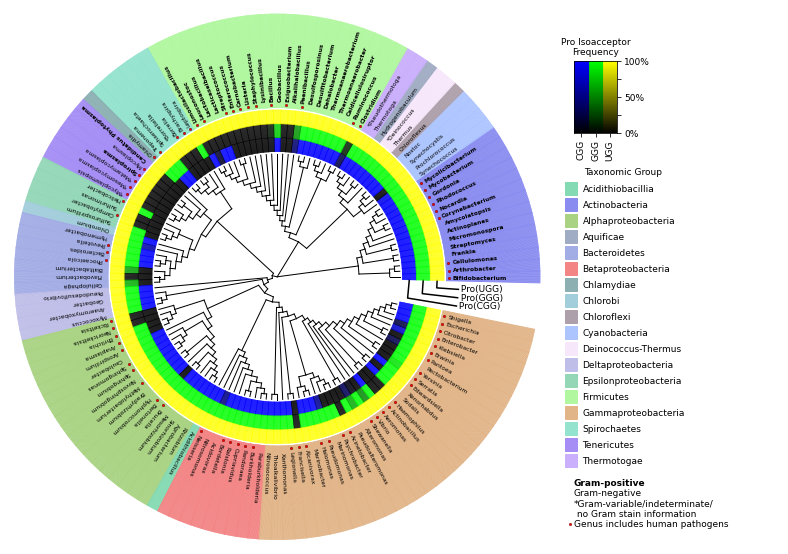

In [57]:
"""
Draw circular tree. 
- Add on Pro-GGG presence/absence within each genus as a ring
- Add on Gram + / Gram - as a ring
- Add on genus names
- Shade areas of the tree by phylum 
"""
import matplotlib.font_manager
def drawCircularTreeBottomUp(axes, tree, center, radius, leafPlacement, leafColors = False, rotation = 0):
    """
    Program to draw circular tree with specified radius and rotation, centered at a specified (x, y) coordinate.
    Branch colors can be specified by adding the colorKey attribute to the ete3 tree, and providing a leafColors
    dictionary
    
    
    Requires
    matplotlib.pyplot (imported as plt)
    ete3 tree
    numpy (imported as np)
    
    
    Inputs:
    
    axes - matplotlib axes object
    
    tree - ete3 tree object
    
    center - coordinates to place center of circular tree (x, y)
    
    radius - radius of tree
    
    leafPlacement - placement angle of leaves along the tree in  in the form of {leaf.name: angle}
        to achieve, write some code like this:
        
        leafPlacement = {}
        for angle, leaf in zip(np.linspace(0, 2 * np.pi, len(tree.get_leaves())), tree.get)_leaves:
            leafPlacement[leaf.name] = angle
        
    leafColors - Optional dictionary of form {colorKey: color}. Will collor branches with leaves with the same colorKey value
        to use leafColors, you must add a colorKey attribute to each leaf in the tree before calling the function
        
        leafKey = {0: 'red', 1: 'blue'}
        for leaf in tree.get_leaves():
            if condition:
                leaf.add_attributes(colorKey = 0)
            else:
                leaf.add_attributes(colorKey = 1)
    
    rotation - optional additional rotation for circular tree
    
    Function returns leafPlacement dictionary with updated rotation for additional plotting
    
    """
    
    #Store x and y coordinates of line segments as a positional list for plotting
    xCoords = []
    yCoords = []
    
    nodeRads = {} #Store node: [radians, radius] for each node
    
    colors = []
    
    #nodeCoords = {} # Store coordinates for nodes for later reference
    
    def checkColoring(node, defaultColor = 'black'):
        
        if leafColors != False:
            leafCols = set(n.colorKey for n in node.get_leaves())
            if len(leafCols) == 1:
                node.add_features(colorKey = list(leafCols)[0])
                
            else:
                #node.add_features(colorKey = defaultColor)
                pass
        else:
            pass
        
    def getMaxSplits():
        """Get max number of splits that occur to be able to properly space splits across radius"""
        splits = []
        for n in tree.get_leaves():
            splits.append(len(n.get_ancestors()))
        
        return max(splits)
    
    def rotateLeafPlacement():
        for x in leafPlacement.keys():
            leafPlacement[x] = leafPlacement[x] + rotation
    
    def doStuff(node):
        
        #xCo = []
        #yCo = []
        nRot = []
        nRad = []
        cols = []
        
        checkColoring(node)
        
        #Get iterate through child nodes
        for child in node.get_children():
            
            if child.name in nodeRads.keys(): #If node already exists, and sis already exists
                checkColoring(child)
                #If node has defined coords, proceed
                coords = nodeRads[child.name]
                
                nRot.append(coords[0])
                nRad.append(coords[1])
                
                try:
                    cols.append(leafColors[node.colorKey])
                except (TypeError, AttributeError) as e: #Handle no anticodon attribute specified
                    cols.append('black')
                
            #Handle leaf placement
            elif child.name in leafPlacement.keys():
                
                nodeRads[child.name] = (leafPlacement[child.name], radius)
                
                coords = nodeRads[child.name]
                
                nRot.append(coords[0])
                nRad.append(coords[1])
                
                try:
                    cols.append(leafColors[child.colorKey])
                except (TypeError, AttributeError) as e: #Handle no anticodon attribute specified
                    cols.append('black')
                
            else:
                doStuff(child)
        
        pRot = np.mean(nRot)
        pRad = min(nRad) - dR
        nodeRads[node.name] = (pRot, pRad)
        
        def tX(radius, rotation):
            """Convert radius and rotation to x coordinate"""
            return radius * np.cos(rotation)
        
        def tY(radius, rotation):
            """Convert radius and rotation to y coordinate"""
            return radius * np.sin(rotation)
        
        for ro, ra, c in zip(nRot, nRad, cols):
            
            #Append outward line
            xCoords.append([tX(pRad, pRot), tX(pRad, ro)])
            yCoords.append([tY(pRad, pRot), tY(pRad, ro)])
            colors.append(c)
            
            #Append horizontal line
            xCoords.append([tX(pRad, ro), tX(ra, ro)])
            yCoords.append([tY(pRad, ro), tY(ra, ro)])
            colors.append(c)
            
    #Apply rotation to leaf placements
    rotateLeafPlacement()
    
    #Get required radius change to fit within a circle
    dR = radius / getMaxSplits()
    
    #Next, recursively iterate through branch nodes
    for n, node in enumerate(tree.traverse("postorder")):
        
        if node.is_leaf() == False: #Skip leaves since laready done
            node.name = n
            doStuff(node)
        
        else:
            pass
    
    
    #Switch to numpy array and transform to specified center point
    xCoords = np.array(xCoords)
    yCoords = np.array(yCoords)
        
    xCoords = xCoords + center[0]
    yCoords = yCoords + center[1]
    
    #Plot lines
    for x, y, c in zip(xCoords, yCoords, colors):
        #print(x, y)
        axes.plot(x, y, color = c, linewidth = 1)
    
    return leafPlacement

#Update font
#plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Arial'})


#Generate tree figure
fw = 12
fh = 8
plt.figure(figsize = (fw, fh))
dist = 22

pw = 7.5
pDisp = 0.25
tAx = plt.axes([pDisp/fw, pDisp/fh, pw/fw, pw/fh], xlim = [-dist, dist], ylim = [-dist, dist], xticks = [], yticks = [])  

treeRad = 10
newPos = drawCircularTreeBottomUp(tAx, tree, (0, 0), treeRad, spLeafRotation)
tAx.axis('off')

#################################################################################################
#Plot Pro-GGG frequency and physical features
d = 0.6
tickWidth = np.pi * 2 / len(tree.get_leaves())
proStart = treeRad + 0.2
proEnd = proStart + 3*d
gramStart = proEnd + 0.2
gramEnd = gramStart + d
medStart = gramEnd + 0.2
medEnd = medStart + d

labelRad = medEnd + 0.2
dist = (medEnd-proStart)/3

proColors = {'Pro-CGG':np.array([0, 0, 1]), 'Pro-GGG':np.array([0, 1, 0]), 'Pro-UGG':np.array([1, 1, 0])}

def getX(radius, angle):
    return radius * np.cos(angle)
def getY(radius, angle):
    return radius * np.sin(angle)

for n in tree.get_leaves():
    
    name = n.name
    
    pos = newPos[name]
    
    
    g = gram.loc[name, 'gram']
    m = gram.loc[name, 'med']
    #print(g)
    phyCol = phyColors[n.colorKey]
    
    
    #Plot genus Pro isoacceptor frequencies
    
    for x, ia in zip(np.linspace(proStart, medEnd, 4), proFreqs.columns.values):
        freq = proFreqs.loc[name, ia]
        
        col = (proColors[ia] * freq)
        
        #Add circular marks
        for l in np.linspace(pos - tickWidth / 2, pos + tickWidth / 2, 20):
            
            tAx.plot([getX(x, l), getX(x + dist, l)], [getY(x, l), getY(x + dist, l)], 
                     linewidth = 0.5, color = col)
    
    #Add circular marks
    for l in np.linspace(pos - tickWidth / 2, pos + tickWidth / 2, 20):
        
        #Plot genus color
        tAx.plot([getX(labelRad, l), getX(labelRad + 7.6, l)], [getY(labelRad, l), getY(labelRad + 7.6, l)], 
                 linewidth = 1, color = 1- (phyCol / 2))
        
    #Add genus labels (shift clockwise slightly due to weird offset)
    
    if str(g) == '1':
        tAx.text(getX(labelRad + 0.5, pos - tickWidth/2), getY(labelRad + 0.5, pos - tickWidth/3), name, ha = 'left', rotation = np.rad2deg(pos), 
                     fontsize = 6, rotation_mode = 'anchor', weight = 'bold')
    elif str(g) == '0':
        tAx.text(getX(labelRad + 0.5, pos - tickWidth/2), getY(labelRad + 0.5, pos - tickWidth/3), name, ha = 'left', rotation = np.rad2deg(pos), 
                     fontsize = 6, rotation_mode = 'anchor')
    else:
        tAx.text(getX(labelRad + 0.5, pos - tickWidth/2), getY(labelRad + 0.5, pos - tickWidth/3), '*' + name, ha = 'left', rotation = np.rad2deg(pos), 
                     fontsize = 6, rotation_mode = 'anchor')
    
        
    if m == 1: #
        tAx.scatter([getX(labelRad + 0.2, pos - np.pi/360)], [getY(labelRad + 0.2, pos - np.pi/360)], color = 'red', zorder = 6,
                    s = 7, edgecolors = 'black', linewidths = 0.25)

##################################################################################################
# Generate labels for each ring
labels = {' Medical significance': [[medStart + d/2, medStart + d/2, medStart + d/2 + 0.5], 
                                   [0-tickWidth/2, 0 - 3*tickWidth/2,  0 - 3* tickWidth/2]],
          ' Gram Stain': [[gramStart + d/2, gramStart + d/2, medStart + d/2 + 0.5], 
                         [0-tickWidth/2, 0 - 5* tickWidth/2,  0 - 5* tickWidth/2]],
          ' Pro Frequency across genus': [[proStart + 3*d/2, proStart + 3*d/2, medStart + 3*d/2 + 0.5], 
                                             [0-tickWidth/2, 0 - 7* tickWidth/2,  0 - 7* tickWidth/2]]}
    
for r, l, a in zip(np.linspace(proStart, medEnd, 4), ['Pro(CGG)', 'Pro(GGG)', 'Pro(UGG)'], [0 - 7*tickWidth/2, 0 - 5*tickWidth/2, 0 - 3*tickWidth/2]):
    
    rads = [r + dist/2, r + dist/2, labelRad + 1]
    rots = [0-tickWidth/2, a, a]
    
    x = [getX(r, a) for r,a in zip(rads, rots)]
    y = [getY(r, a) for r,a in zip(rads, rots)]
    
    tAx.plot(x, y, color = 'black', zorder = 0)
    tAx.text(x[-1], y[-1],' ' + l, fontsize = 9, va = 'center')
    
#################################################################################################
# Phylum color key
phyW = 1.6
phyH = 4
phyKey = plt.axes([(pw + 2* pDisp)/fw, (pDisp + 1.75)/fw, phyW/fw, phyH/fh], title = 'Taxonomic Groups', 
                 ylim = [0, len(phyColors.keys())], xticks = [], 
                 xlim = [0, 1], yticks = [])
phyKey.axis('off')
phyKey.set_title('Taxonomic Group', fontsize = 9)
for y, c in enumerate(sorted(phyColors.keys(), reverse = True)):
    r = pat.Rectangle([0, y + 0.1], 0.1, 0.8, color = 1 - (phyColors[c]/2) )
    phyKey.add_patch(r)
    
    phyKey.text(0.15, y + 0.5, c, va = 'center', fontsize = 9)
    
###########################################################################################################
# Pro-GGG frequency color key
proW = 0.6
proH = 1

proKey = plt.axes([(pw + 2.5* pDisp)/fw, 6/fh, proW/fw, proH/fh], title = 'Pro Isoacceptor\nFrequency', 
                 ylim = [0, 1], yticks = [0, 0.25, 0.5, 0.75, 1], yticklabels = ['0%', '', '50%', '', '100%'],
                 xlim = [0, 3], xticks = [0.5, 1.5, 2.5], xticklabels = ['CGG', 'GGG', 'UGG'])
#proKey.axis('off')


for y in np.arange(0, 1, 0.01):
    
    for x, col in enumerate(proColors.keys()):
        
        c = proColors[col] * y
        r = pat.Rectangle([x, y], 1, 0.01, color = c)
        proKey.add_patch(r)

proKey.yaxis.tick_right()
proKey.set_yticklabels(proKey.get_yticklabels(), fontsize = 9)
proKey.set_xticklabels(proKey.get_xticklabels(), rotation = 90, fontsize = 9)
proKey.set_title('Pro Isoacceptor\nFrequency', fontsize = 9)

###########################################################################################################
# Pro-GGG frequency color key
labelW = 3
labelH = 0.7

labelKey = plt.axes([(pw + 2 * pDisp)/fw, 3* pDisp/fw, labelW/fw, labelH/fh], 
                 ylim = [0, 5], yticks  = [], xticks = [],
                 xlim = [0, 5])

labelKey.axis('off')


labelKey.text(0.2, 4.5, 'Gram-positive', ha = 'left', va = 'center', fontsize = 9, weight = 'bold')
labelKey.text(0.2, 3.5, 'Gram-negative', ha = 'left', va = 'center', fontsize = 9)
labelKey.text(0.2, 2, '*Gram-variable/indeterminate/\n no Gram stain information', ha = 'left', va = 'center', fontsize = 9)
labelKey.text(0.2, 0.5, 'Genus includes human pathogens', ha = 'left', va = 'center', fontsize = 9)
labelKey.scatter(0.1, 0.5, color = 'red', zorder = 6, s = 7, edgecolors = 'black', linewidths = 0.25)

plt.savefig('pro_ggg_phylo_tree_final.png', dpi = 600)

    
 
    

In [40]:
"""
Here, I will create a venn diagram using genera from GtRNAdb
"""

##########################################################################
# Re-calculate pro freqs using all genera
"""
Process Pro-GGG information for addition into figure in next panel
"""
genomeInfo = pd.read_csv('./single_species_gtrnadb_info_with_entrez_taxonomy.txt', sep = '\t', index_col = 0)

iaCounts = pd.read_csv('./gtrnadb_isoacceptor_counts.txt', sep = '\t', index_col = 0).fillna(0)

iaFiltered = iaCounts.loc[genomeInfo.index.values, :]
iaFiltered = iaFiltered.rename(columns = {'Pro-TGG': 'Pro-UGG'})

pro = iaCounts[['Pro-CGG', 'Pro-GGG', 'Pro-TGG']]
pro = pro.rename(columns = {'Pro-TGG': 'Pro-UGG'})

#Get the frequency of tRNA-Pro-GGG occurence across species within genus
proFreqs = pd.DataFrame({'Pro-CGG': [], 'Pro-GGG': [], 'Pro-UGG': []})
for genus in set(genomeInfo['genus']):
    proFreqs.loc['genus', :] = 0
    #Retrieve species in genus
    gen = genomeInfo[genomeInfo['genus'] == genus]
    for ia in proFreqs.columns.values:
        
        genCounts = pro.loc[gen.index.values, ia]
        proPos = genCounts[genCounts > 0]
        pos = len(proPos.index.values)
        tot = len(genCounts.index.values)
    
        proFreqs.loc[genus, ia] = pos/tot

gram['Pro-GGG_freq'] = 0
for genus in gram.index.values:
    try: #Skip Coprococcus. rRNA prob wasn't retrieved since switching to combined
        gram.loc[genus, 'Pro-GGG_freq'] = proFreqs.loc[genus, 'Pro-GGG']
    except KeyError:
        print(genus)
        

print(gram)

Coprococcus
Blautia
Faecalibacterium
Kosakonia
Paeniclostridium
                      Pro-CGG  Pro-GGG  Pro-UGG
genus                     0.0      0.0      0.0
Hirschia                  0.0      1.0      1.0
Nonlabens                 0.0      0.5      1.0
Hafnia                    0.0      1.0      1.0
Megalodesulfovibrio       1.0      1.0      1.0
...                       ...      ...      ...
Porphyromonas             1.0      1.0      1.0
Endomicrobium             0.0      1.0      1.0
Caldicellulosiruptor      1.0      1.0      1.0
Rhodobacter               1.0      1.0      1.0
Actinobacillus            0.0      0.0      1.0

[757 rows x 3 columns]
                 count gram  med                                pmid  \
genus                                                                  
Pseudomonas         37    0  1.0                            31701321   
Corynebacterium     30    1  1.0                            27155209   
Streptococcus       29    1  1.0                

                 count gram  med                                pmid  \
genus                                                                  
Pseudomonas         37    0  1.0                            31701321   
Corynebacterium     30    1  1.0                            27155209   
Streptococcus       29    1  1.0                            29600772   
Bacillus            25    1  1.0                   31111815_30521647   
Burkholderia        22    0  1.0                            27620956   
...                ...  ...  ...                                 ...   
Xanthobacter         1  NaN  0.0  34410902_31296671_34882528_9103627   
Xylanimonas          1    1  0.0                   33394210_31976851   
Xylella              1    0  0.0                            28642764   
Zunongwangia         1    0  0.0                   24002475_30361977   
Zymomonas            1    0  0.0                            26803757   

                 Pro-GGG_freq  
genus                          

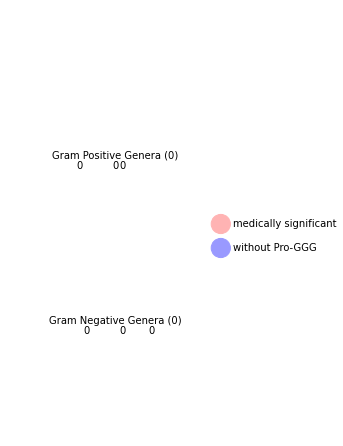

In [45]:
#Get set of gram positive genera and those lacking Pro-GGG

gramP = gram[gram['gram'] == 1]
gp = set(gramP.index.values)

noGramP = gramP[gramP['Pro-GGG_freq'] < 0.5]
ngp = set(noGramP.index.values)
print(len(ngp))
medNoGramP = noGramP[noGramP['med'] == 1.0]
mngp = set(medNoGramP.index.values)
print(len(mngp))
withGramP = gramP[gramP['Pro-GGG_freq'] >= 0.5]
medWGramP = withGramP[withGramP['med'] == 1.0]
mwgp = set(medWGramP.index.values)

#Get set of gram negative genera and those lacking Pro-GGG
gramN = gram[gram['gram'] == 0]
gn = set(gramN.index.values)

noGramN = gramN[gramN['Pro-GGG_freq'] < 0.5]
ngn = set(noGramN.index.values)
print(len(ngn))
medNoGramN = noGramN[noGramN['med'] == 1.0]
mngn = set(medNoGramN.index.values)
print(len(mngn))
withGramN = gramN[gramN['Pro-GGG_freq'] >= 0.5]
medWGramN = withGramN[withGramN['med'] == 1.0]
mwgn = set(medWGramN.index.values)



fw = 6
fh = 7
plt.figure(figsize = (fw, fh))

pw = 3
ph = 6
venn = plt.axes([0.5/fw, 0.5/fh, pw/fw, ph/fh], xlim = [-15, 15], ylim = [-30, 30])
venn.axis('off')

def getRadius(area):
    return np.sqrt(area/np.pi)

px = 0
py = 8

gpc = pat.Circle([px, py], getRadius(len(gp)), color = (0, 0, 0), alpha = 0.1)
#plt.text(px , py - 5, len(gp) - (len(ngp) + len(mwgp)), ha = 'center', va = 'center')

gnpc = pat.Circle([px + getRadius(len(gp))  - getRadius(len(ngp)) - 1.5, py], getRadius(len(ngp)), color = (0, 0, 1), alpha = 0.2)
plt.text(px + 1 + getRadius(len(gp)) - (getRadius(len(ngp))), py, len(ngp) - len(mngp), ha = 'center', va = 'center')

mgp = pat.Circle([px - 2, py], getRadius(len(mngp) + len(mwgp)), color = (1, 0, 0), alpha = 0.3)
plt.text(px - 5 + getRadius(len(gp)) - (getRadius(len(mngp))), py, len(mngp), ha = 'center', va = 'center')

#mgwpc = pat.Circle([px - getRadius(len(gp)) + getRadius(len(mwgp)), py], getRadius(len(mwgp)), color = (1, 0, 0))
plt.text(px - getRadius(len(gp)) + getRadius(len(mwgp)), py, len(mwgp), ha = 'center', va = 'center')

venn.add_patch(gpc)
venn.add_patch(gnpc)
venn.add_patch(mgp)
#venn.add_patch(mgwpc)
plt.text(0, py + getRadius(len(gp)) + 1, 'Gram Positive Genera ({0})'.format(len(gp)),ha = 'center')

nx = 0
ny = -15

gnc = pat.Circle([nx, ny], getRadius(len(gn)), color = (0, 0, 0), alpha = 0.1)
#plt.text(nx, ny - 7, len(gn) - (len(ngn) + len(mwgn)), ha = 'center', va = 'center')

gnnc = pat.Circle([nx + 3.5, ny], getRadius(len(ngn)), color = (0, 0, 1), alpha = 0.2)
plt.text(nx + 5, ny, len(ngn) - len(mngn), ha = 'center', va = 'center')

mgn = pat.Circle([nx -2, ny], getRadius(len(mngn) + len(mwgn)), color = (1, 0, 0), alpha = 0.3)
plt.text(nx + 1, ny, len(mngn), ha = 'center', va = 'center')

#mgwnc = pat.Circle([nx - getRadius(len(gn)) + getRadius(len(mwgn)), ny], getRadius(len(mwgn)), color = (1, 0, 0))
plt.text(nx - 4, ny, len(mwgn), ha = 'center', va = 'center')

venn.add_patch(gnc)
venn.add_patch(gnnc)
venn.add_patch(mgn)
plt.text(nx, ny + getRadius(len(gn)) + 1, 'Gram Negative Genera ({0})'.format(len(gn)), ha = 'center')

#Venn labels
venn.plot()

######################################################################################
# Add color key
key = plt.axes([3.3/fw, 2.65/fh, 1/fw, 1/fh], xlim = [0, 3], ylim = [0, 3], zorder = 5)
key.axis('off')
for y, c, t in zip([1, 2], [ (0.6, 0.6, 1), (1, 0.7, 0.7)], 
                ['without Pro-GGG', 'medically significant']):
    r = pat.Circle([0.5, y + 0.5], 0.4, color = c)
    key.add_patch(r)
    key.text(1, y + 0.5, t, va = 'center')

plt.savefig('Pro-GGG_Venn_V2.png', dpi = 600)

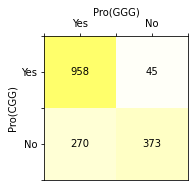

In [46]:
"""
Here's an additional 2x2 table figure showing the distribution of with/without Pro-GGG and Pro-CGG
"""

#Filter Pro df to contain one assrmbly per species
pro = pro.loc[dbSet, : ]
proSize = len(pro.index.values)


withCGG = pro[pro['Pro-CGG'] >= 1]
noCGG = pro[pro['Pro-CGG'] == 0]

withGGG = pro[pro['Pro-GGG'] >= 1]
noGGG = pro[pro['Pro-GGG'] == 0]

#Create 2x2 table figure
fs = 4
plt.figure(figsize = (fs, fs))

#Set up axes
ps = 2
ax = plt.axes([1/fs, 1/fs, ps/fs, ps/fs], title = '', #'Nonessential Pro\nisoacceptor frequencies',
              xlim = [0, 2], xticks = [0, 0.5, 1, 1.5, 2], xticklabels = ['', 'Yes', '', 'No', ''], xlabel = 'Pro(GGG)',
              ylim = [0, 2], yticks = [0, 0.5, 1, 1.5, 2], yticklabels = ['', 'No', '', 'Yes', ''], ylabel = 'Pro(CGG)')


ax.xaxis.tick_top()
ax.xaxis.set_tick_params(labeltop=True)
ax.xaxis.set_label_position('top') 

#Fill in table
wgwc = withGGG[withGGG['Pro-CGG'] > 0]
wgwcCount = len(wgwc.index.values)
ax.text(0.5, 1.5, str(wgwcCount), ha = 'center', va = 'center' )
wgwcR = pat.Rectangle([0, 1], 1, 1, color = np.array([1,1,1 - wgwcCount/proSize]) )
ax.add_patch(wgwcR)

wgnc = withGGG[withGGG['Pro-CGG'] == 0]
wgncCount = len(wgnc.index.values)
ax.text(0.5, 0.5, str(wgncCount), ha = 'center', va = 'center' )
wgncR = pat.Rectangle([0, 0], 1, 1, color = np.array([1, 1, 1 - wgncCount/proSize]) )
ax.add_patch(wgncR)

ngwc = withCGG[withCGG['Pro-GGG'] == 0]
ngwcCount = len(ngwc.index.values)
ax.text(1.5, 1.5, str(ngwcCount), ha = 'center', va = 'center' )
ngwcR = pat.Rectangle([1, 1], 1, 1, color = np.array([1,1, 1 - ngwcCount/proSize]) )
ax.add_patch(ngwcR)

ngnc = noCGG[noCGG['Pro-GGG'] == 0]
ngncCount = len(ngnc.index.values)
ax.text(1.5, 0.5, str(ngncCount), ha = 'center', va = 'center' )
ngncR = pat.Rectangle([1, 0], 1, 1, color = np.array([1,1,1 - ngncCount/proSize]))
ax.add_patch(ngncR)





plt.savefig('Pro-GGG_Pro-CGG_frequency_comparison_all_gtrnadb_species.png', dpi = 600)

In [12]:
phyloRef = pd.read_csv('../bac_phylo_ref/gtrnadb_rRNAinfo.txt.gz', sep = '\t', index_col = 0)
phyloRef = phyloRef.fillna('')
phyloRef.loc['rhodOpac_R7', :]

#phyloRef['combinedSeq'] = phyloRef['ssu_seq'] + phyloRef['lsu_seq']

ssu = phyloRef[phyloRef['ssu_seq'] == '']
lsu = phyloRef[phyloRef['lsu_seq'] == '']

print(len(set(ssu.index.values).union(set(lsu.index.values))))
#Total 
print(len(phyloRef.index.values) - 86)

86
3958


In [13]:
fullData = pd.read_csv('./single_species_gtrnadb_info_with_entrez_taxonomy.txt', sep = '\t', index_col = 0)

genus = pd.DataFrame({'genus': []})

for g in set(fullData['genus']):
    
    genus.loc[g, 'genus'] = list(fullData['genus']).count(g)
    
genus = genus.sort_values(['genus'], ascending = False)
genus.to_csv('genus_species_counts_gtrnadb.txt', sep = '\t')
